<a href="https://colab.research.google.com/github/ElaYJ/MachineLearning_Project/blob/main/olist_ecommerce_gh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_item = pd.read_csv("olist_order_items_dataset.csv")
order_payment = pd.read_csv("olist_order_payments_dataset.csv")
order_review = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
product_category = pd.read_csv("product_category_name_translation.csv")

In [3]:
# 날짜 데이터 타입 변경
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [4]:
# products에 있는 category_name을 product_category에 있는 product_category_name_english로 변형
product_category_dict = dict(zip(product_category['product_category_name'], product_category['product_category_name_english']))
products['product_category_name'] = products['product_category_name'].map(product_category_dict)

---

# 전체적인 EDA

In [6]:
# A. orders와 customers 합치기
order_customer = pd.merge(orders[['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']],customers[['customer_id','customer_unique_id','customer_state']],how='left',on='customer_id')

# A. payment 합치기
order_customer = pd.merge(order_customer,order_payment[['order_id','payment_value']],how='left',on='order_id')

# B. item과 products 합치기
order_product = pd.merge(order_item[['order_id','product_id']],products[['product_id','product_category_name']])

# A와 B 합치기
order_customer = pd.merge(order_customer,order_product,how='left',on='order_id')

# review 합치기
order_customer=pd.merge(order_customer,order_review[['order_id','review_score']],how='left',on='order_id')

# 연월일 칼럼 생성
order_customer['order_purchase_date'] = pd.to_datetime(order_customer['order_purchase_timestamp'].dt.strftime('%Y-%m-%d'))
order_customer['order_delivered_date'] = pd.to_datetime(order_customer['order_delivered_customer_date'].dt.strftime('%Y-%m-%d'))
order_customer['order_estimated_date'] = pd.to_datetime(order_customer['order_estimated_delivery_date'].dt.strftime('%Y-%m-%d'))

order_customer = order_customer.drop(columns=['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date'])

order_customer['days_to_deliver_actual'] = (order_customer['order_delivered_date'] - order_customer['order_purchase_date']).dt.days
order_customer['days_to_deliver_expected'] = (order_customer['order_estimated_date'] - order_customer['order_purchase_date']).dt.days

order_customer.head(5)

,order_id,customer_id,customer_unique_id,customer_state,payment_value,product_id,product_category_name,review_score,order_purchase_date,order_delivered_date,order_estimated_date,days_to_deliver_actual,days_to_deliver_expected
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,SP,18.12,87285b34884572647811a353c7ac498a,housewares,4.0,2017-10-02,2017-10-10,2017-10-18,8.0,16
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,SP,2.00,87285b34884572647811a353c7ac498a,housewares,4.0,2017-10-02,2017-10-10,2017-10-18,8.0,16
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,SP,18.59,87285b34884572647811a353c7ac498a,housewares,4.0,2017-10-02,2017-10-10,2017-10-18,8.0,16
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,BA,141.46,595fac2a385ac33a80bd5114aec74eb8,perfumery,4.0,2018-07-24,2018-08-07,2018-08-13,14.0,20
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,GO,179.12,aa4383b373c6aca5d8797843e5594415,auto,5.0,2018-08-08,2018-08-17,2018-09-04,9.0,27


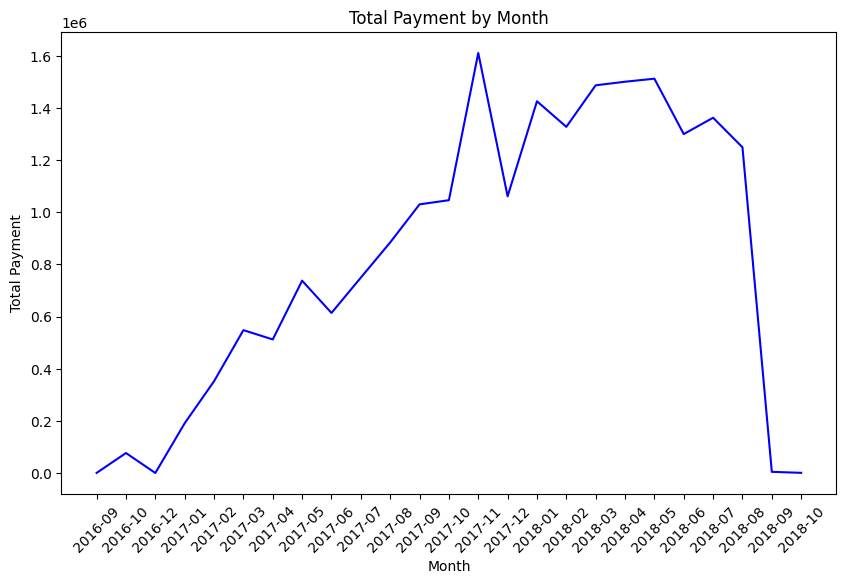

In [8]:
# 연월 칼럼 생성
order_customer['order_month'] = order_customer['order_purchase_date'].dt.strftime('%Y-%m')

# 연월별 결제 금액 합계 계산
monthly_sales = order_customer.groupby('order_month')['payment_value'].sum()

# 선 그래프 생성
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, color='blue')
plt.xlabel('Month')
plt.ylabel('Total Payment')
plt.title('Total Payment by Month')
plt.xticks(rotation=45)
plt.show()


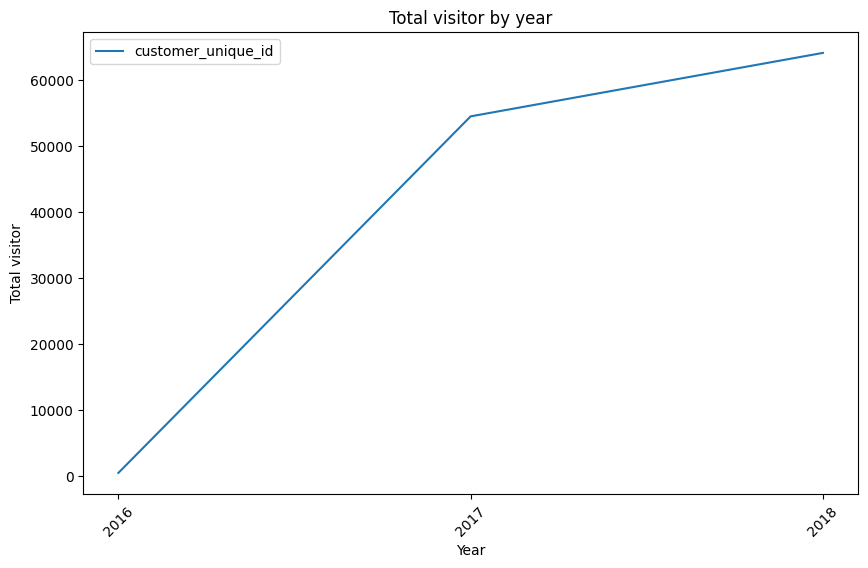

In [49]:
# 연월 칼럼 생성
order_customer['order_year'] = order_customer['order_purchase_date'].dt.strftime('%Y')

# 방문객 합계 계산
yearly_visitor = order_customer.groupby('order_year').agg({'customer_unique_id':len})

# 선 그래프 생성
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_visitor, color='blue')
plt.xlabel('Year')
plt.ylabel('Total visitor')
plt.title('Total visitor by year')
plt.xticks(rotation=45)
plt.show()

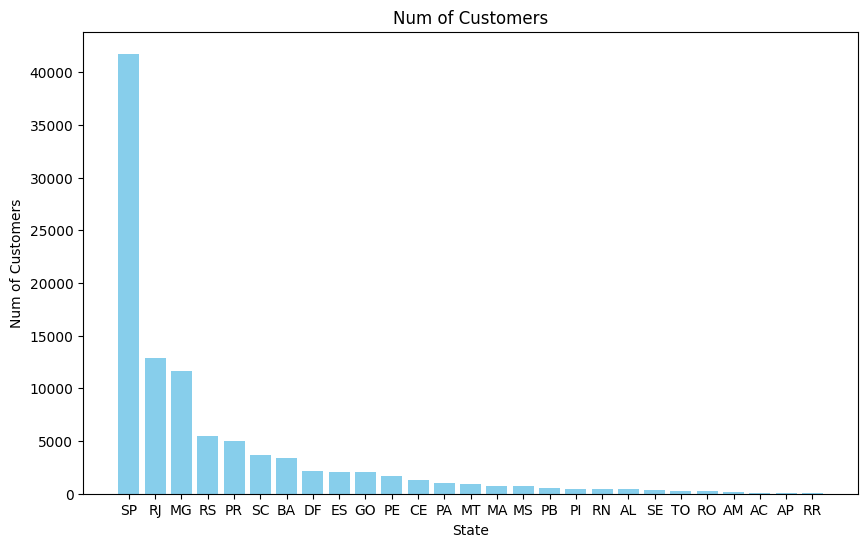

In [9]:
customer_state_group = customers.groupby('customer_state').agg({'customer_state':len}).rename(columns={'customer_state':'customer_cnt'})

# 내림차순 정렬
customer_state_group = customer_state_group.sort_values(by='customer_cnt', ascending=False)

# 막대그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(customer_state_group.index, customer_state_group['customer_cnt'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Num of Customers')
plt.title('Num of Customers')
plt.show()

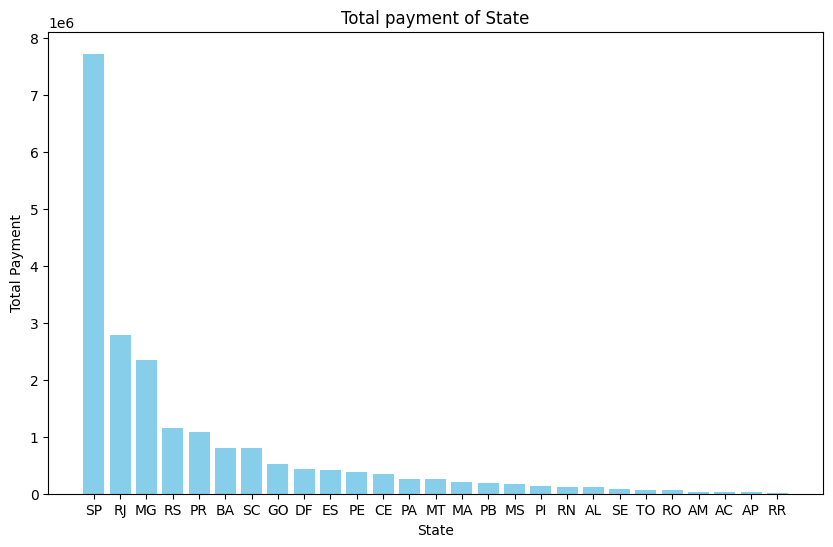

In [10]:
order_customer_state = order_customer.groupby('customer_state').agg({'payment_value':sum}).rename(columns={'payment_value':'total_payment_value'})

# 내림차순 정렬
order_customer_state = order_customer_state.sort_values(by='total_payment_value', ascending=False)

# 막대그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(order_customer_state.index, order_customer_state['total_payment_value'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Payment')
plt.title('Total payment of State')
plt.show()

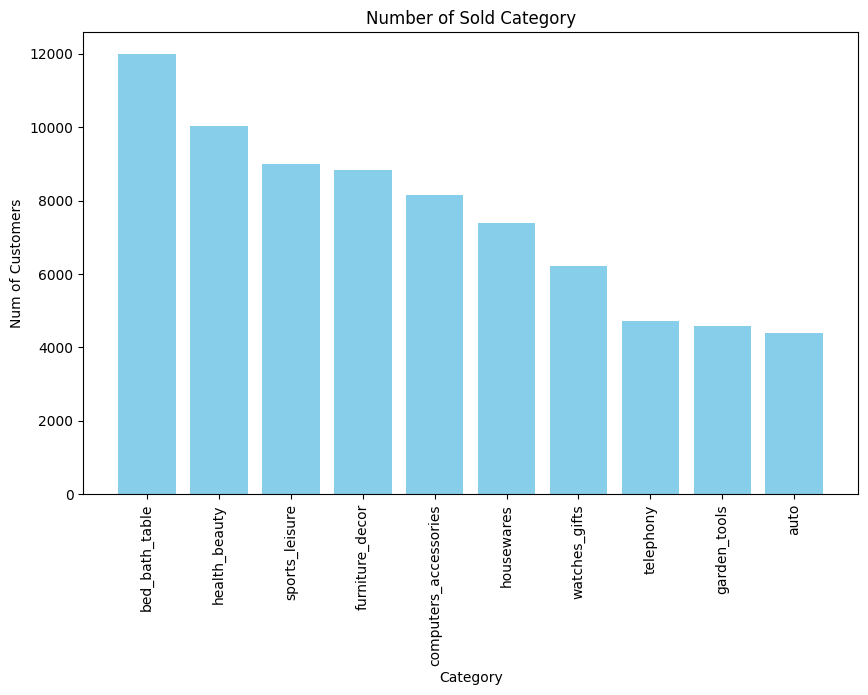

In [11]:
product_group = order_customer.groupby('product_category_name').agg({'customer_state':len}).rename(columns={'customer_state':'Numbers'})

# 내림차순 정렬
product_group = product_group.sort_values(by='Numbers', ascending=False)

# 상위 10개 판매건수 막대그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(product_group.index[:10], product_group['Numbers'][:10], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Num of Customers')
plt.title('Number of Sold Category')
plt.xticks(rotation=90)
plt.show()

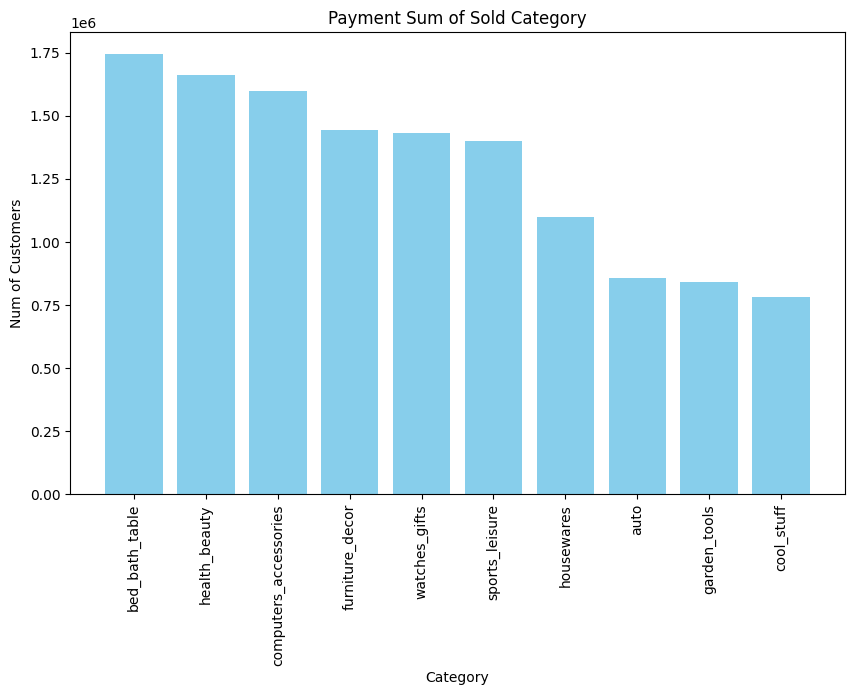

In [12]:
product_group = order_customer.groupby('product_category_name').agg({'payment_value':sum}).rename(columns={'payment_value':'Numbers'})

# 내림차순 정렬
product_group = product_group.sort_values(by='Numbers', ascending=False)

# 상위 10개 판매건수 막대그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(product_group.index[:10], product_group['Numbers'][:10], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Num of Customers')
plt.title('Payment Sum of Sold Category')
plt.xticks(rotation=90)
plt.show()

# 재방문객 분석

In [15]:
train = customers.groupby('customer_unique_id').agg({'customer_id':len}).rename(columns={'customer_id':'visit_cnt'})

train = train.reset_index()

train.head()

,customer_unique_id,visit_cnt
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [13]:
# 재방문 여부
def revisit(visit_cnt):
  if visit_cnt ==1 :
    return False
  else :
    return True

In [16]:
from tqdm import tqdm

for i in tqdm(range(len(train['visit_cnt']))):
  train.loc[i,'revisit']=revisit(train['visit_cnt'][i])

100%|██████████| 96096/96096 [00:12<00:00, 7788.86it/s]


In [18]:
train['revisit'] = train['revisit'].astype('bool')

In [19]:
unique_id_group = order_customer.groupby(['customer_unique_id','order_id']).agg({'order_purchase_date':np.mean})

unique_id_group_sorted = unique_id_group.sort_values(by='order_purchase_date')

# 첫 번째 주문만 남기기
first_orders = unique_id_group_sorted.groupby('customer_unique_id').head(1)

# 결과 확인
first_orders = first_orders.reset_index()

train = pd.merge(train,first_orders[['customer_unique_id','order_id']],how='left',on='customer_unique_id')

In [20]:
train.head()

,customer_unique_id,visit_cnt,revisit,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1,False,e22acc9c116caa3f2b7121bbb380d08e
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,False,3594e05a005ac4d06a72673270ef9ec9
2,0000f46a3911fa3c0805444483337064,1,False,b33ec3b699337181488304f362a6b734
3,0000f6ccb0745a6a4b88665a16c9f078,1,False,41272756ecddd9a9ed0180413cc22fb6
4,0004aac84e0df4da2b147fca70cf8255,1,False,d957021f1127559cd947b62533f484f7


In [21]:
mean_group = order_customer.groupby('order_id').agg({'payment_value':np.mean,'review_score':np.mean,'days_to_deliver_actual':np.mean,'days_to_deliver_expected':np.mean})
mean_group = mean_group.reset_index()
train = pd.merge(train,mean_group,how='left',on='order_id')

train.head()

,customer_unique_id,visit_cnt,revisit,order_id,payment_value,review_score,days_to_deliver_actual,days_to_deliver_expected
0,0000366f3b9a7992bf8c76cfdf3221e2,1,False,e22acc9c116caa3f2b7121bbb380d08e,141.90,5.0,6.0,11.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,False,3594e05a005ac4d06a72673270ef9ec9,27.19,4.0,3.0,8.0
2,0000f46a3911fa3c0805444483337064,1,False,b33ec3b699337181488304f362a6b734,86.22,3.0,26.0,28.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,False,41272756ecddd9a9ed0180413cc22fb6,43.62,4.0,20.0,32.0
4,0004aac84e0df4da2b147fca70cf8255,1,False,d957021f1127559cd947b62533f484f7,196.89,5.0,13.0,21.0


In [22]:
train['actual/expected'] = train['days_to_deliver_actual'] / train['days_to_deliver_expected']

train.head()

,customer_unique_id,visit_cnt,revisit,order_id,payment_value,review_score,days_to_deliver_actual,days_to_deliver_expected,actual/expected
0,0000366f3b9a7992bf8c76cfdf3221e2,1,False,e22acc9c116caa3f2b7121bbb380d08e,141.90,5.0,6.0,11.0,0.545455
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,False,3594e05a005ac4d06a72673270ef9ec9,27.19,4.0,3.0,8.0,0.375000
2,0000f46a3911fa3c0805444483337064,1,False,b33ec3b699337181488304f362a6b734,86.22,3.0,26.0,28.0,0.928571
3,0000f6ccb0745a6a4b88665a16c9f078,1,False,41272756ecddd9a9ed0180413cc22fb6,43.62,4.0,20.0,32.0,0.625000
4,0004aac84e0df4da2b147fca70cf8255,1,False,d957021f1127559cd947b62533f484f7,196.89,5.0,13.0,21.0,0.619048


In [23]:
id_state = order_customer.groupby(['order_id','customer_state']).agg({'review_score':np.mean}).reset_index().drop(columns=['review_score'])
train = pd.merge(train,id_state,how='left',on='order_id')

id_category = order_customer.groupby(['order_id','product_category_name']).agg({'review_score':np.mean}).reset_index().drop(columns=['review_score'])
train = pd.merge(train,id_category,how='left',on='order_id')

In [24]:
train.head()

,customer_unique_id,visit_cnt,revisit,order_id,payment_value,review_score,days_to_deliver_actual,days_to_deliver_expected,actual/expected,customer_state,product_category_name
0,0000366f3b9a7992bf8c76cfdf3221e2,1,False,e22acc9c116caa3f2b7121bbb380d08e,141.90,5.0,6.0,11.0,0.545455,SP,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,False,3594e05a005ac4d06a72673270ef9ec9,27.19,4.0,3.0,8.0,0.375000,SP,health_beauty
2,0000f46a3911fa3c0805444483337064,1,False,b33ec3b699337181488304f362a6b734,86.22,3.0,26.0,28.0,0.928571,SC,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,1,False,41272756ecddd9a9ed0180413cc22fb6,43.62,4.0,20.0,32.0,0.625000,PA,telephony
4,0004aac84e0df4da2b147fca70cf8255,1,False,d957021f1127559cd947b62533f484f7,196.89,5.0,13.0,21.0,0.619048,SP,telephony


In [25]:
train=train.dropna()

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92022 entries, 0 to 96782
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        92022 non-null  object 
 1   visit_cnt                 92022 non-null  int64  
 2   revisit                   92022 non-null  bool   
 3   order_id                  92022 non-null  object 
 4   payment_value             92022 non-null  float64
 5   review_score              92022 non-null  float64
 6   days_to_deliver_actual    92022 non-null  float64
 7   days_to_deliver_expected  92022 non-null  float64
 8   actual/expected           92022 non-null  float64
 9   customer_state            92022 non-null  object 
 10  product_category_name     92022 non-null  object 
dtypes: bool(1), float64(5), int64(1), object(4)
memory usage: 7.8+ MB


In [27]:
true_rate = len(train[train['revisit']==True])/len(train) * 100
print(f'재방문 고객 비율은 {round(true_rate,2)}% 입니다.')

재방문 고객 비율은 3.11% 입니다.


# 시각화

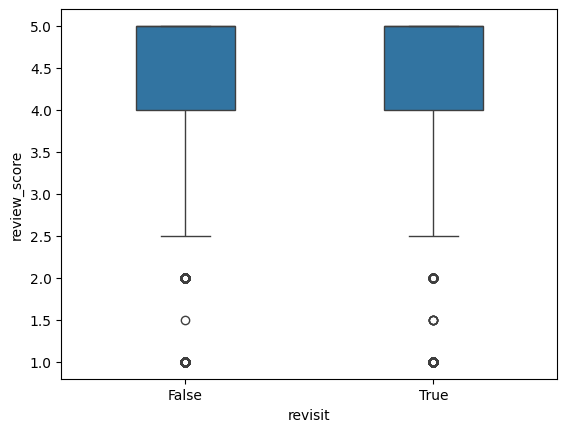

In [28]:
sns.boxplot(x='revisit',y='review_score',data=train,width=0.4)

plt.show()

리뷰 스코어 자체가 재방문에 큰 영향은 미치지 못 했습니다.

> 들여쓴 블록



In [29]:
payment_avg = order_customer.groupby('customer_unique_id').agg({'payment_value':np.mean}).rename(columns={'payment_value':'payment_avg'})
payment_avg = payment_avg.reset_index()
train = pd.merge(train,payment_avg,how='left',on='customer_unique_id')

train.head(3)

,customer_unique_id,visit_cnt,revisit,order_id,payment_value,review_score,days_to_deliver_actual,days_to_deliver_expected,actual/expected,customer_state,product_category_name,payment_avg
0,0000366f3b9a7992bf8c76cfdf3221e2,1,False,e22acc9c116caa3f2b7121bbb380d08e,141.90,5.0,6.0,11.0,0.545455,SP,bed_bath_table,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,False,3594e05a005ac4d06a72673270ef9ec9,27.19,4.0,3.0,8.0,0.375000,SP,health_beauty,27.19
2,0000f46a3911fa3c0805444483337064,1,False,b33ec3b699337181488304f362a6b734,86.22,3.0,26.0,28.0,0.928571,SC,stationery,86.22


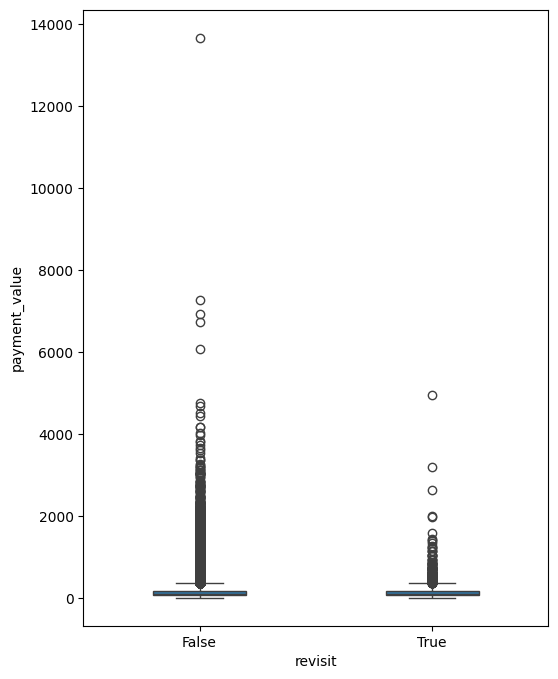

In [30]:
plt.figure(figsize=(6,8))
sns.boxplot(x='revisit',y='payment_value',data=train,width=0.4)

plt.show()

재방문에 평균 구매액도 영향을 미치지 못한 것으로 보입니다. 오히려 처음 6000 이상으로 산 사람이 재방문을 안하는 경우도 있는 것을 확인할 수 있습니다.

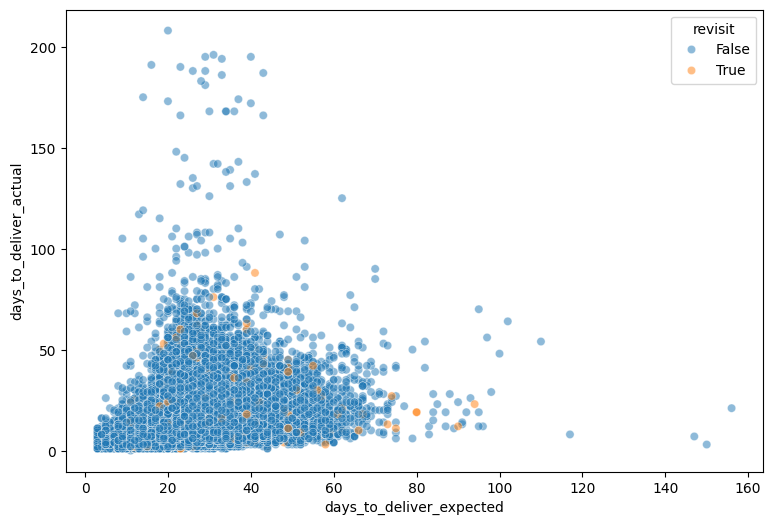

In [31]:
plt.figure(figsize=(9,6))
sns.scatterplot(x='days_to_deliver_expected',y='days_to_deliver_actual',hue='revisit',data=train,alpha=0.5)

plt.show()

만약 주황점이 특정 기울기에 많이 분포했다면 실제 배송일과 예정 배송일의 일정 비율을 맞출수록 재방문율이 높다는 가설을 입증할 수 있습니다. 하지만 주황점의 분포의 규칙성을 찾을 수 없다는 것을 확인 할 수 있습니다. 각각의 값이 100을 넘으면 재방문을 하지 않는다는 것을 확인할 수 있습니다.

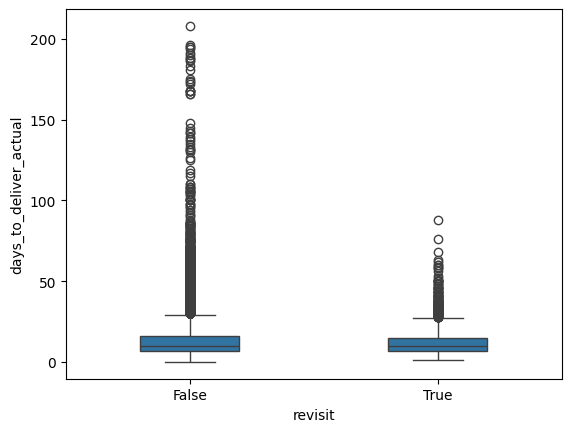

In [32]:
sns.boxplot(x='revisit',y='days_to_deliver_actual',data=train,width=0.4)

plt.show()

배송일이 100일을 넘은 경우 재방문을 하지 않은 것을 확인할 수 있습니다. 하지만 그 수는 적기 때문에 유의미한 데이터라고 하기에는 어려운 부분이 있습니다.

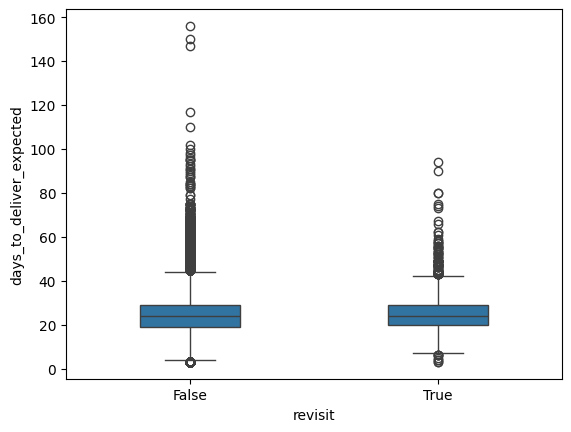

In [33]:
sns.boxplot(x='revisit',y='days_to_deliver_expected',data=train,width=0.4)

plt.show()

마찬가지로 예상 배송일이 100일 이상이면 재방문을 하지 않는 것을 확인할 수 있습니다.

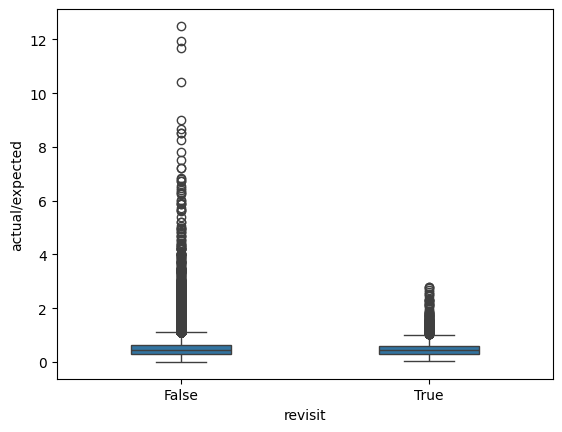

In [34]:
sns.boxplot(x='revisit',y='actual/expected',data=train,width=0.4)

plt.show()

In [35]:
rate_true=[]; rate_false=[];

for feat in np.sort(train['customer_state'].unique()):
    cnt_true = len(train[(train['customer_state']==feat) & (train['revisit']==True)]['customer_unique_id'])
    cnt_false = len(train[(train['customer_state']==feat) & (train['revisit']==False)]['customer_unique_id'])

    total_tmp = cnt_true + cnt_false

    rate_true.append(cnt_true/total_tmp)
    rate_false.append(cnt_false/total_tmp)

result_df = pd.DataFrame({
    'True': rate_true,
    'False': rate_false,
}, index = np.sort(train['customer_state'].unique()))

result_df = result_df.sort_values(by='True',ascending=False)
result_df.head(10)

#result_df.plot(kind='barh', figsize=(14,8), stacked = True, alpha = 0.7, colormap='summer')
#plt.xlabel('rate')
#plt.ylabel('state')
#plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

#plt.show()

,True,False
AC,0.054054,0.945946
RO,0.035556,0.964444
GO,0.034501,0.965499
RJ,0.033952,0.966048
MT,0.033097,0.966903
RS,0.032384,0.967616
SP,0.032150,0.967850
PR,0.031608,0.968392
DF,0.030715,0.969285
MG,0.030498,0.969502


In [36]:
rate_true=[]; rate_false=[];

for feat in np.sort(train['product_category_name'].unique()):
    cnt_true = len(train[(train['product_category_name']==feat) & (train['revisit']==True)]['customer_unique_id'])
    cnt_false = len(train[(train['product_category_name']==feat) & (train['revisit']==False)]['customer_unique_id'])

    total_tmp = cnt_true + cnt_false

    rate_true.append(cnt_true/total_tmp)
    rate_false.append(cnt_false/total_tmp)

result_df = pd.DataFrame({
    'True': rate_true,
    'False': rate_false,
}, index = np.sort(train['product_category_name'].unique()))

result_df = result_df.sort_values(by='True',ascending=False)
result_df.head(10)

,True,False
arts_and_craftmanship,0.142857,0.857143
fashion_childrens_clothes,0.142857,0.857143
la_cuisine,0.090909,0.909091
home_appliances,0.089552,0.910448
fashion_male_clothing,0.079208,0.920792
furniture_bedroom,0.059524,0.940476
fashio_female_clothing,0.058824,0.941176
fashion_bags_accessories,0.058091,0.941909
furniture_mattress_and_upholstery,0.057143,0.942857
furniture_living_room,0.053299,0.946701


---

# 머신러닝

In [37]:
target = train['revisit']
X_train = train.drop(columns=['customer_unique_id','visit_cnt','revisit','order_id'])

In [38]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)

# 학습 데이터
train_encoded = onehot_encoder.fit_transform(X_train[['customer_state','product_category_name']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_columns = ['payment_value','review_score','days_to_deliver_actual','days_to_deliver_expected','actual/expected']
train_numeric_scaled = scaler.fit_transform(X_train[numeric_columns])

In [40]:
train_combined = np.hstack((train_numeric_scaled, train_encoded))

In [41]:
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k_fold=KFold(n_splits=5,random_state=0,shuffle=True)

In [42]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

xgbc = XGBClassifier()
predicted = cross_val_predict(xgbc, train_combined, target, cv=k_fold, n_jobs=1)
report = classification_report(target, predicted)

print(report)

              precision    recall  f1-score   support

       False       0.97      1.00      0.98     89156
        True       0.81      0.01      0.01      2866

    accuracy                           0.97     92022
   macro avg       0.89      0.50      0.50     92022
weighted avg       0.96      0.97      0.95     92022



---

# Olist VS Other Ecommerce (2018)

In [60]:
olist_total_visitor = len(order_customer[order_customer['order_year']=='2018']['customer_unique_id'].unique())

df_ecommerce = pd.DataFrame({
    'Sites':['MercadoLibre','Amazon Sites','B2W Digital','Alibaba','eBay','CNova','Apple sites','Walmart','Google Shopping','Buscape','OList'],
    'Visitors':[56300000,22400000,16100000,11800000,9500000,9100000,8400000,7700000,7500000,6000000,olist_total_visitor]
    })

total_tmp = sum(df_ecommerce['Visitors'])
df_ecommerce['Percentage(%)'] = round((df_ecommerce['Visitors'] / total_tmp) * 100,2)

df_ecommerce

,Sites,Visitors,Percentage(%)
0,MercadoLibre,56300000,36.36
1,Amazon Sites,22400000,14.47
2,B2W Digital,16100000,10.40
3,Alibaba,11800000,7.62
4,eBay,9500000,6.13
5,CNova,9100000,5.88
6,Apple sites,8400000,5.42
7,Walmart,7700000,4.97
8,Google Shopping,7500000,4.84
9,Buscape,6000000,3.87


---

K 평균 군집

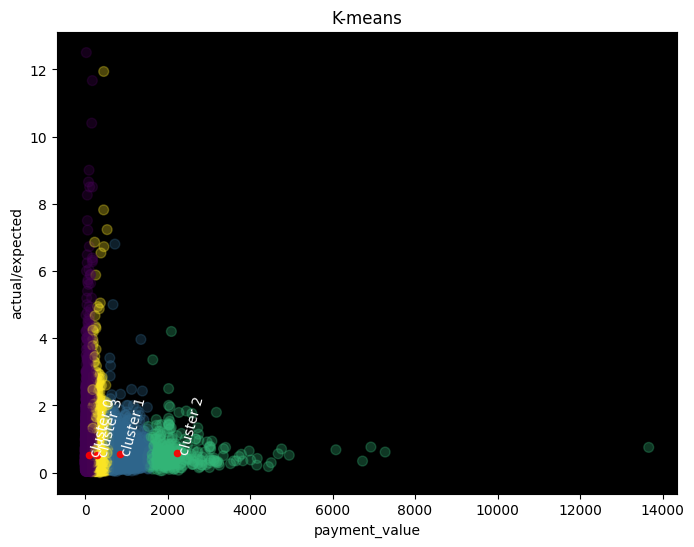

Cluster 0: 71094(True 비중:3.1 %)
Cluster 1: 2842(True 비중:2.3 %)
Cluster 2: 367(True 비중:1.6 %)
Cluster 3: 17719(True 비중:3.3 %)


In [153]:
from sklearn.cluster import KMeans

xy = ['payment_value','actual/expected']

X = train[xy]

# K-means 알고리즘 적용
random_state = 20
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
kmeans.fit(X)

# 클러스터 중심점과 클러스터 할당 결과
centers = kmeans.cluster_centers_
labels = kmeans.labels_
.≥≥plt.figure(figsize=(8, 6))

# 결과 시각화

# 클러스터 할당 결과 시각화
plt.scatter(X[xy[0]], X[xy[1]], c=labels, cmap='viridis', s=50, alpha=0.3)

# 클러스터 중심점 시각화
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.9)
for i in range(len(centers)):
  plt.text(centers[i][0],centers[i][1],f'cluster {i}',color = 'white',rotation=75)

plt.title('K-means')
plt.xlabel(xy[0])
plt.ylabel(xy[1])
plt.gca().set_facecolor('black')
plt.show()

# 클러스터 할당 결과를 새로운 열로 추가
train['cluster'] = kmeans.labels_

# 각 클러스터마다 어떤 데이터가 포함되어 있는지 확인
for cluster_id in range(n_clusters):  # 클러스터 개수에 따라 범위 설정
    cluster_data = train[train['cluster'] == cluster_id]
    cluster_true_data = train[(train['cluster'] == cluster_id) & (train['revisit']==True)]
    true_perc = round((len(cluster_true_data) / len(cluster_data)) * 100,1)
    print(f'Cluster {cluster_id}: {len(cluster_data)}(True 비중:{true_perc} %)')


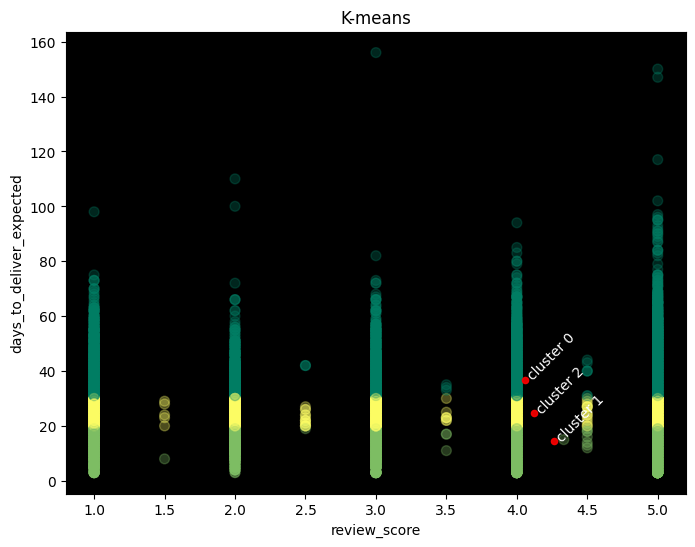

Cluster 0: 18965(True 비중:3.4 %)
Cluster 1: 24753(True 비중:2.7 %)
Cluster 2: 48304(True 비중:3.2 %)


In [142]:
xy = ['review_score','days_to_deliver_expected']

X = train[xy]

# K-means 알고리즘 적용
random_state = 20
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
kmeans.fit(X)

# 클러스터 중심점과 클러스터 할당 결과
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# 결과 시각화
plt.figure(figsize=(8, 6))

# 클러스터 할당 결과 시각화
plt.scatter(X[xy[0]], X[xy[1]], c=labels, cmap='summer', s=50, alpha=0.3)

# 클러스터 중심점 시각화
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.9)
for i in range(len(centers)):
  plt.text(centers[i][0],centers[i][1],f'cluster {i}',color = 'w',rotation=45)

plt.title('K-means')
plt.xlabel(xy[0])
plt.ylabel(xy[1])
plt.gca().set_facecolor('black')
plt.show()

# 클러스터 할당 결과를 새로운 열로 추가
train['cluster'] = kmeans.labels_

# 각 클러스터마다 어떤 데이터가 포함되어 있는지 확인
for cluster_id in range(n_clusters):  # 클러스터 개수에 따라 범위 설정
    cluster_data = train[train['cluster'] == cluster_id]
    cluster_true_data = train[(train['cluster'] == cluster_id) & (train['revisit']==True)]
    true_perc = round((len(cluster_true_data) / len(cluster_data)) * 100,1)
    print(f'Cluster {cluster_id}: {len(cluster_data)}(True 비중:{true_perc} %)')

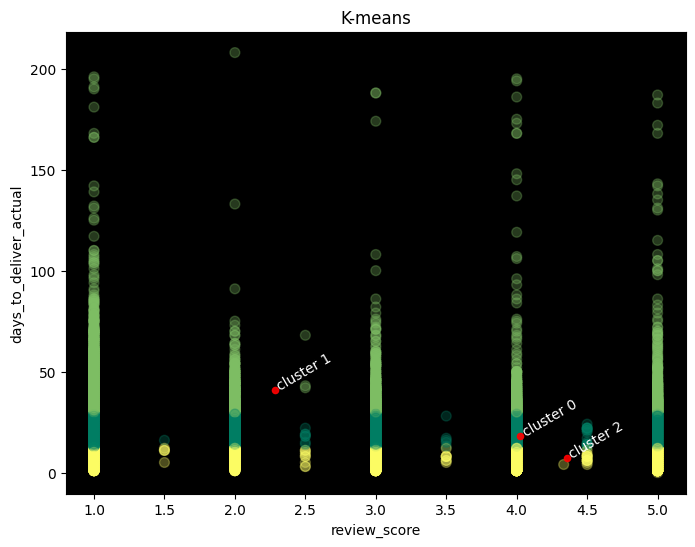

Cluster 0: 30098(True 비중:3.3 %)
Cluster 1: 4425(True 비중:2.7 %)
Cluster 2: 57499(True 비중:3.1 %)


In [147]:
xy = ['review_score','days_to_deliver_actual']

X = train[xy]

# K-means 알고리즘 적용
random_state = 20
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
kmeans.fit(X)

# 클러스터 중심점과 클러스터 할당 결과
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# 결과 시각화
plt.figure(figsize=(8, 6))

# 클러스터 할당 결과 시각화
plt.scatter(X[xy[0]], X[xy[1]], c=labels, cmap='summer', s=50, alpha=0.3)

# 클러스터 중심점 시각화
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.9)
for i in range(len(centers)):
  plt.text(centers[i][0],centers[i][1],f'cluster {i}',rotation=30,color='white')

plt.title('K-means')
plt.xlabel(xy[0])
plt.ylabel(xy[1])
plt.gca().set_facecolor('black')
plt.show()

# 클러스터 할당 결과를 새로운 열로 추가
train['cluster'] = kmeans.labels_

# 각 클러스터마다 어떤 데이터가 포함되어 있는지 확인
for cluster_id in range(n_clusters):  # 클러스터 개수에 따라 범위 설정
    cluster_data = train[train['cluster'] == cluster_id]
    cluster_true_data = train[(train['cluster'] == cluster_id) & (train['revisit']==True)]
    true_perc = round((len(cluster_true_data) / len(cluster_data)) * 100,1)
    print(f'Cluster {cluster_id}: {len(cluster_data)}(True 비중:{true_perc} %)')

실제 배송일이 약 30을 넘은 경우(cluster 1) 평균 리뷰 점수가 낮은 것을 확인할 수 있습니다.

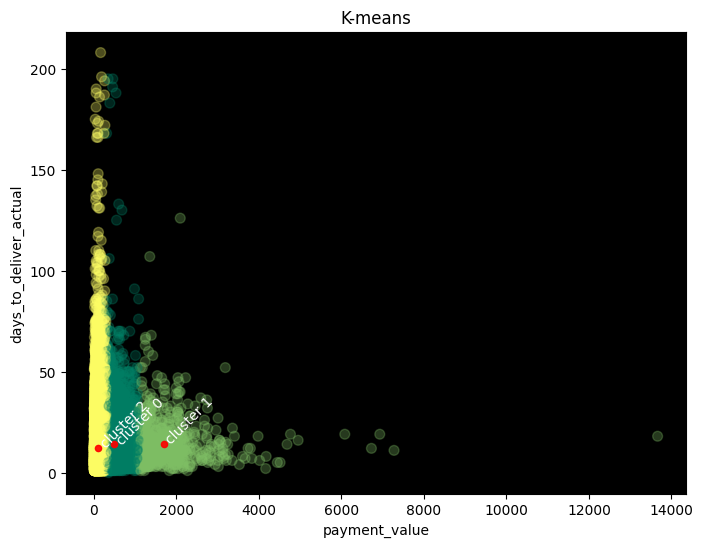

Cluster 0: 8768(True 비중:2.7 %)
Cluster 1: 846(True 비중:2.0 %)
Cluster 2: 82408(True 비중:3.2 %)


In [156]:
xy = ['payment_value','days_to_deliver_actual']

X = train[xy]

# K-means 알고리즘 적용
random_state = 20
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
kmeans.fit(X)

# 클러스터 중심점과 클러스터 할당 결과
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# 결과 시각화
plt.figure(figsize=(8, 6))

# 클러스터 할당 결과 시각화
plt.scatter(X[xy[0]], X[xy[1]], c=labels, cmap='summer', s=50, alpha=0.3)

# 클러스터 중심점 시각화
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.9)
for i in range(len(centers)):
  plt.text(centers[i][0],centers[i][1],f'cluster {i}',color = 'w',rotation=45)

plt.title('K-means')
plt.xlabel(xy[0])
plt.ylabel(xy[1])
plt.gca().set_facecolor('black')
plt.show()

# 클러스터 할당 결과를 새로운 열로 추가
train['cluster'] = kmeans.labels_

# 각 클러스터마다 어떤 데이터가 포함되어 있는지 확인
for cluster_id in range(n_clusters):  # 클러스터 개수에 따라 범위 설정
    cluster_data = train[train['cluster'] == cluster_id]
    cluster_true_data = train[(train['cluster'] == cluster_id) & (train['revisit']==True)]
    true_perc = round((len(cluster_true_data) / len(cluster_data)) * 100,1)
    print(f'Cluster {cluster_id}: {len(cluster_data)}(True 비중:{true_perc} %)')

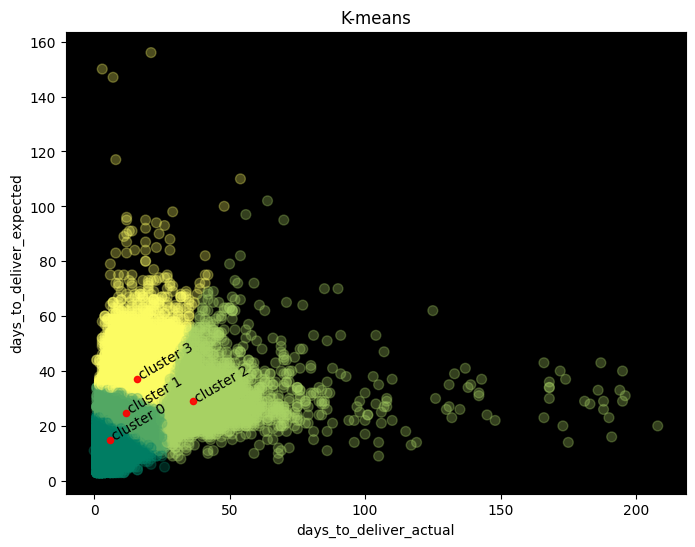

Cluster 0: 25864(True 비중:2.8 %)
Cluster 1: 44023(True 비중:3.2 %)
Cluster 2: 6543(True 비중:2.6 %)
Cluster 3: 15592(True 비중:3.5 %)


In [141]:
xy = ['days_to_deliver_actual','days_to_deliver_expected']

X = train[xy]

# K-means 알고리즘 적용
random_state = 20
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
kmeans.fit(X)

# 클러스터 중심점과 클러스터 할당 결과
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# 결과 시각화
plt.figure(figsize=(8, 6))

# 클러스터 할당 결과 시각화
plt.scatter(X[xy[0]], X[xy[1]], c=labels, cmap='summer', s=50, alpha=0.3)

# 클러스터 중심점 시각화
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.9)
for i in range(len(centers)):
  plt.text(centers[i][0],centers[i][1],f'cluster {i}',rotation=30)

plt.title('K-means')
plt.xlabel(xy[0])
plt.ylabel(xy[1])
plt.gca().set_facecolor('black')
plt.show()

# 클러스터 할당 결과를 새로운 열로 추가
train['cluster'] = kmeans.labels_

# 각 클러스터마다 어떤 데이터가 포함되어 있는지 확인
for cluster_id in range(n_clusters):  # 클러스터 개수에 따라 범위 설정
    cluster_data = train[train['cluster'] == cluster_id]
    cluster_true_data = train[(train['cluster'] == cluster_id) & (train['revisit']==True)]
    true_perc = round((len(cluster_true_data) / len(cluster_data)) * 100,1)
    print(f'Cluster {cluster_id}: {len(cluster_data)}(True 비중:{true_perc} %)')